What is K-Fold Cross Validation? It basically consists of iteratively splitting the dataset into "folds" (which are kind of subsets) of equal size. Every iteration, k-1 folds are used for  training and 1 fold is used for validation, and validation fold is rotated until all folds are used. Every fold iteration, a metric is calculated (in our case, the loss function is evaluated). A batch size to determine how many samples at a time to update parameters is, then, defined. 

In [27]:
import xarray as xr
import numpy as np
import gsw

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as functional
from torch.utils.data import Subset, Dataset
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing import Generator

In [28]:
from funcs import concatenateTupleList, pathList, iter_and_returnXrds # past functions I wrote

In [29]:
from kfcvFunctions import dataset, createDataLoader, kFoldCrossValidation, kFoldTrain, plotTrainAndValLosses, resRed # also functions I wrote, but for KFCV implementation. this just cleans the nb a bit

In [30]:
numberIdArr = pathList()
xrdsList = iter_and_returnXrds(numberIdArr)

/home/arthur/.conda/envs/flab/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/arthur/.conda/envs/flab/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [31]:
dataArr = concatenateTupleList(xrdsList, "TEMP", "LATITUDE", "LONGITUDE", "PRES_ADJUSTED", "PSAL_ADJUSTED", "N_PROF")

In [41]:
X = np.array([x[0] for x in dataArr], dtype=np.float32)  # temperature
y = np.array([x[4] for x in dataArr], dtype=np.float32) # practical salinity
lat = np.array([x[1] for x in dataArr], dtype=np.float32) # latitude
lon = np.array([x[2] for x in dataArr], dtype=np.float32) # longitude
pres = np.array([x[3] for x in dataArr], dtype=np.float32) # pressure
prof = np.zeros_like(X) # this is here just to build the contour lines

Text(0, 0.5, 'Temperature (°C)')

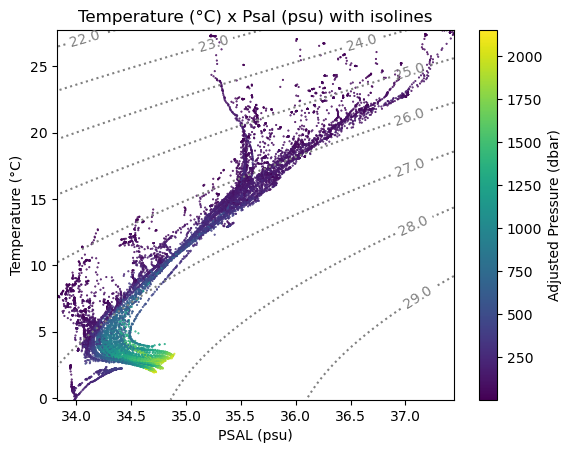

In [33]:
plt.scatter(y, X, c=pres, s=0.25, cmap='viridis') # T-S diagram. since the variable "y" is in the x-axis, the code looks a bit weird
plt.colorbar(label="Adjusted Pressure (dbar)")

sal_grid = np.linspace(np.min(y), np.max(y), 100) # calculating each grid
temp_grid = np.linspace(np.min(X), np.max(X), 100)
SAL, TEMP = np.meshgrid(sal_grid, temp_grid) 


SA_grid = gsw.SA_from_SP(SAL, 0, lon.mean(), lat.mean())
CT_grid = gsw.CT_from_t(SA_grid, TEMP, 0)


sigma_grid = gsw.sigma0(SA_grid, CT_grid)


cs = plt.contour(SAL, TEMP, sigma_grid, levels=np.arange(20, 30, 1), colors='gray', linestyles='dotted') 
plt.clabel(cs, fmt="%.1f")
plt.title("Temperature (°C) x Psal (psu) with isolines")
plt.xlabel("PSAL (psu)")
plt.ylabel("Temperature (°C)") 

In [42]:
X = X.reshape(-1,1) # reshaping all the arrays to fit the shape needed to enter the NN
y = y.reshape(-1,1) 
pres = pres.reshape(-1,1)
lat = lat.reshape(-1,1)
lon = lon.reshape(-1,1) 

scalerY = StandardScaler() # defining scalers to normalize the vectors. naming the scalers this way avoids some weird errors where python doesn't recognize the variable as being normalized (and therefore doesn't have an inverse normalization)  
scalerX = StandardScaler() 
scalerPres = StandardScaler()

X = scalerX.fit_transform(X) # normalization
y = scalerY.fit_transform(y)
pres = scalerPres.fit_transform(pres)
lat = np.sin(lat * np.pi/180)
lon = np.sin(lon * np.pi/180)

inVector = np.column_stack((X, lat, lon, pres)) # creating the input vector as (T, Lat, Lon, P)

In [43]:
class Model(nn.Module): # criação da classe modelo; herda nn.Module do PyTorch
    def __init__(self, inFeatures = 4, h1 = 512, h2 = 256, h3 = 128, h4 = 64, h5 = 32, outFeatures=1): # (PSAL, LAT, LON, PRES)--> h1 --> h2 --> ... --> TEMP 
        super().__init__() # instanciando nn.Module
        self.fullyConnected1 = nn.Linear(inFeatures, h1) # connecting each layer with z = wX + b
        self.fullyConnected2 = nn.Linear(h1, h2)
        self.fullyConnected3 = nn.Linear(h2, h3)
        self.fullyConnected4 = nn.Linear(h3, h4)
        self.fullyConnected5 = nn.Linear(h4, h5)
        self.out = nn.Linear(h5, outFeatures)

    def forward(self, x): # forward propagation 
        x = functional.relu(self.fullyConnected1(x)) # using ReLU as an activation function
        x = functional.relu(self.fullyConnected2(x))
        x = functional.relu(self.fullyConnected3(x))
        x = functional.relu(self.fullyConnected4(x))
        x = functional.relu(self.fullyConnected5(x))
        x = self.out(x)

        return x

In [44]:
model = Model() # instantiating the model
torchSet = dataset(inVector, y) # instantiating the "dataset" class, also imported from kfcvFunctions.py

In [45]:
lossCriterion = nn.MSELoss() # using mse as loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # using adam as optim

In [46]:
numEpochs = 100 # the number of epochs can be decreased to increase performance, since we're going to be doing, at max, 100 epochs * 10 folds = 1000 "training sessions"
generatorObj = kFoldCrossValidation(torchSet, 1024, 10)
lossListPlot, valLossListPlot = kFoldTrain(model, numEpochs, lossCriterion, optimizer,generatorObj)
# it's worth noting that the kFoldTrain function includes an automatic stoppage criterion, which stops the fold iteration if the loss value plateaus for 10 epochs in a fold.

---------------------------------------------------------------
Fold: 1
Epoch: 0 	 Batches: 12 	 Loss: 0.0892268642783165
Epoch: 1 	 Batches: 12 	 Loss: 0.09123586118221283
Epoch: 2 	 Batches: 12 	 Loss: 0.06827925145626068
Epoch: 3 	 Batches: 12 	 Loss: 0.06614206731319427
Epoch: 4 	 Batches: 12 	 Loss: 0.07902388274669647
Epoch: 5 	 Batches: 12 	 Loss: 0.047884225845336914
Epoch: 6 	 Batches: 12 	 Loss: 0.03845173865556717
Epoch: 7 	 Batches: 12 	 Loss: 0.04249643161892891
Epoch: 8 	 Batches: 12 	 Loss: 0.047565948218107224
Epoch: 9 	 Batches: 12 	 Loss: 0.050144262611866
Epoch: 10 	 Batches: 12 	 Loss: 0.04911184310913086
Epoch: 11 	 Batches: 12 	 Loss: 0.04504481703042984
Epoch: 12 	 Batches: 12 	 Loss: 0.04206725209951401
Epoch: 13 	 Batches: 12 	 Loss: 0.041106101125478745
Epoch: 14 	 Batches: 12 	 Loss: 0.04169882833957672
Epoch: 15 	 Batches: 12 	 Loss: 0.04299984872341156
Epoch: 16 	 Batches: 12 	 Loss: 0.04413501173257828
Epoch: 17 	 Batches: 12 	 Loss: 0.04498567432165146
Ep

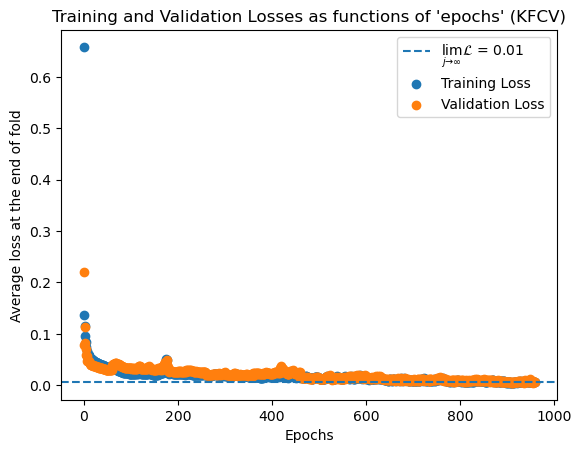

In [47]:
plotTrainAndValLosses(lossListPlot, valLossListPlot) # plotting training loss and validation loss

In [14]:
with torch.no_grad(): # evaluating original dataset with the model
    outs = model(torch.tensor(inVector))
    outs = scalerY.inverse_transform(outs.numpy())

In [15]:
invVec =  np.column_stack((scalerX.inverse_transform(X), np.arcsin(lat)*180/(np.pi), np.arcsin(lon)*180/(np.pi), scalerPres.inverse_transform(pres)))

X_og =  np.array([x[0] for x in dataArr], dtype=np.float32)  # this has no need, but I like to be safe (if it doesn't sacrifice performance in a big way)
y_og = np.array([x[4] for x in dataArr], dtype=np.float32)
pres_og = np.array([x[3] for x in dataArr], dtype=np.float32)
lat_vec = np.array([x[1] for x in invVec], dtype=np.float32)
lon_vec = np.array([x[2] for x in invVec], dtype=np.float32)

yNonNormalized = scalerX.inverse_transform(y_og.reshape(-1,1))
torch.Tensor.ndim = property(lambda self: len(self.shape)) 

Text(0, 0.5, 'Temperature (°C)')

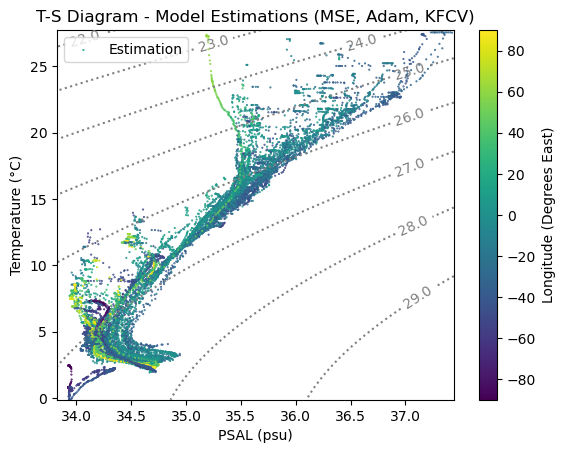

In [25]:
plt.scatter(outs, X_og, c=lon_vec,s=0.25, cmap="viridis") #  plotting model estimations to verify it holds the same "shape"
plt.colorbar(label="Longitude (Degrees East)")
sal_grid = np.linspace(np.min(y_og), np.max(y_og), 100)
temp_grid = np.linspace(np.min(X_og), np.max(X_og), 100)
SAL, TEMP = np.meshgrid(sal_grid, temp_grid)

# SA, CT
SA_grid = gsw.SA_from_SP(SAL, 0, lon_vec.mean(), lat_vec.mean())
CT_grid = gsw.CT_from_t(SA_grid, TEMP, 0)


sigma_grid = gsw.sigma0(SA_grid, CT_grid)


cs = plt.contour(SAL, TEMP, sigma_grid, levels=np.arange(20, 30, 1), colors='gray', linestyles='dotted')
plt.clabel(cs, fmt="%.1f")
plt.title("T-S Diagram - Model Estimations (MSE, Adam, KFCV)")
plt.legend(("Estimation", "_"))
plt.xlabel("PSAL (psu)")
plt.ylabel("Temperature (°C)")

0

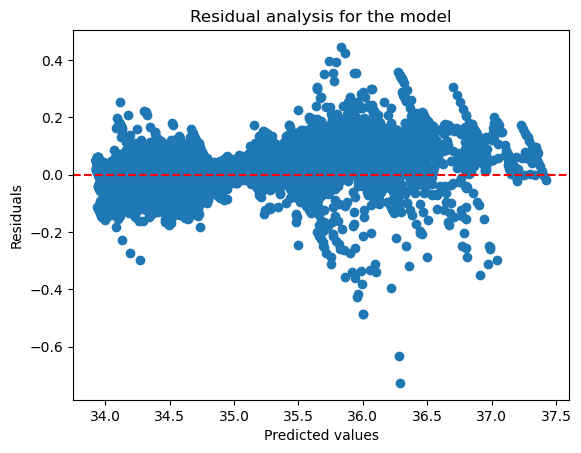

In [17]:
resRed(y_og, outs) # residual analysis to check if there exists clear patterns 

In [26]:
torch.save(model.state_dict(), "kfcvTPLL.pt")